In [158]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from esem import rf_model
from eofs.xarray import Eof
import itertools


In [2]:
train_files= ['ssp126', 'ssp585', 'picontrol']

In [3]:
NEOFS = 5

In [5]:
training_data_path = './inputs/'

def get_Xtrain(datasets, n_eofs=5):
    """
    Args:
        datasets list(str): dataset to create features for
        n_eofs (int): number of eofs to create
    """
    
    if isinstance(datasets, str):
        datasets = [datasets]
        
    X = xr.concat([xr.open_dataset(training_data_path+f'inputs_{d}.nc') for d in datasets], dim='time')
    X = X.assign_coords(time=np.arange(len(X.time)))
    
    # compute eofs for pr
    pr_solver = Eof(X['pr'])
    pr_eofs = pr_solver.eofsAsCorrelation(neofs=n_eofs)
    pr_pcs = pr_solver.pcs(npcs=n_eofs, pcscaling=1)
    # to pandas dataframe
    pr_df = pr_pcs.to_dataframe().unstack('mode')
    pr_df.columns = [f"pr_{i}" for i in range(n_eofs)]

    # compute eofs for rlds
    rlds_solver = Eof(X['rlds'])
    rlds_eofs = rlds_solver.eofsAsCorrelation(neofs=n_eofs)
    rlds_pcs = rlds_solver.pcs(npcs=n_eofs, pcscaling=1)
    # to pandas dataframe
    rlds_df = pr_pcs.to_dataframe().unstack('mode')
    rlds_df.columns = [f"rlds_{i}" for i in range(n_eofs)]

    # compute eofs for rlds
    rsds_solver = Eof(X['rsds'])
    rsds_eofs = rsds_solver.eofsAsCorrelation(neofs=n_eofs)
    rsds_pcs = rsds_solver.pcs(npcs=n_eofs, pcscaling=1)
    # to pandas dataframe
    rsds_df = rsds_pcs.to_dataframe().unstack('mode')
    rsds_df.columns = [f"rsds_{i}" for i in range(n_eofs)]

    # compute eofs for sfcwind
    sfcwind_solver = Eof(X['sfcwind'])
    sfcwind_eofs = sfcwind_solver.eofsAsCorrelation(neofs=n_eofs)
    sfcwind_pcs = sfcwind_solver.pcs(npcs=n_eofs, pcscaling=1)
    # to pandas dataframe
    sfcwind_df = sfcwind_pcs.to_dataframe().unstack('mode')
    sfcwind_df.columns = [f"sfcwind_{i}" for i in range(n_eofs)]

    # compute eofs for sfcwind
    tas_solver = Eof(X['tas'])
    tas_eofs = tas_solver.eofsAsCorrelation(neofs=n_eofs)
    tas_pcs = tas_solver.pcs(npcs=n_eofs, pcscaling=1)
    # to pandas dataframe
    tas_df = tas_pcs.to_dataframe().unstack('mode')
    tas_df.columns = [f"tas_{i}" for i in range(n_eofs)]

    # compute eofs for sfcwind
    tasmax_solver = Eof(X['tasmax'])
    tasmax_eofs = tasmax_solver.eofsAsCorrelation(neofs=n_eofs)
    tasmax_pcs = tasmax_solver.pcs(npcs=n_eofs, pcscaling=1)
    # to pandas dataframe
    tasmax_df = tasmax_pcs.to_dataframe().unstack('mode')
    tasmax_df.columns = [f"tasmax_{i}" for i in range(n_eofs)]

    # compute eofs for sfcwind
    tasmin_solver = Eof(X['tasmin'])
    tasmin_eofs = tasmin_solver.eofsAsCorrelation(neofs=n_eofs)
    tasmin_pcs = tasmin_solver.pcs(npcs=n_eofs, pcscaling=1)
    # to pandas dataframe
    tasmin_df = tasmin_pcs.to_dataframe().unstack('mode')
    tasmin_df.columns = [f"tasmin_{i}" for i in range(n_eofs)]
    
    
    inputs=pd.concat([pr_df, rlds_df, rsds_df, sfcwind_df, tas_df, tasmax_df, tasmin_df], axis=1)
    
    return inputs, (pr_solver, rlds_solver, rsds_solver, sfcwind_solver, tas_solver, tasmax_solver, tasmin_solver)

In [6]:
Xtrain, eof_solvers = get_Xtrain(train_files, NEOFS)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [9]:
def get_Ytrain(datasets):
        
    if isinstance(datasets, str):
        datasets = [datasets]
        
    Y = xr.concat([xr.open_dataset(f'./processed_output/lpjml_{d}_2015_2100.nc') for d in datasets], dim='time')
    
    return Y

In [10]:
Ytrain_mai = get_Ytrain(train_files)['mai'].values.reshape(-1, 360*720)

In [11]:
training_data_path = './inputs/'
def get_Xtest(file, eof_solvers, n_eofs=5):
    # pr_solver, rlds_solver, rsds_solver, sfcwind_solver, tas_solver, tasmax_solver, tasmin_solver
    X = xr.open_dataset(training_data_path+f'inputs_{file}.nc')

    pr_pcs = eof_solvers[0].projectField(X['pr'], neofs=n_eofs, eofscaling=1)
    pr_df = pr_pcs.to_dataframe().unstack('mode')
    pr_df.columns = [f"pr_{i}" for i in range(n_eofs)]

    rlds_pcs = eof_solvers[1].projectField(X['rlds'], neofs=n_eofs, eofscaling=1)
    rlds_df = rlds_pcs.to_dataframe().unstack('mode')
    rlds_df.columns = [f"rlds_{i}" for i in range(n_eofs)]

    rsds_pcs = eof_solvers[2].projectField(X['rsds'], neofs=n_eofs, eofscaling=1)
    rsds_df = rsds_pcs.to_dataframe().unstack('mode')
    rsds_df.columns = [f"rsds_{i}" for i in range(n_eofs)]

    sfcwind_pcs = eof_solvers[0].projectField(X['sfcwind'], neofs=n_eofs, eofscaling=1)
    sfcwind_df = sfcwind_pcs.to_dataframe().unstack('mode')
    sfcwind_df.columns = [f"sfcwind_{i}" for i in range(n_eofs)]
    
    tas_pcs = eof_solvers[0].projectField(X['tas'], neofs=n_eofs, eofscaling=1)
    tas_df = tas_pcs.to_dataframe().unstack('mode')
    tas_df.columns = [f"tas_{i}" for i in range(n_eofs)]
    
    tasmax_pcs = eof_solvers[0].projectField(X['tasmax'], neofs=n_eofs, eofscaling=1)
    tasmax_df = tasmax_pcs.to_dataframe().unstack('mode')
    tasmax_df.columns = [f"tasmax_{i}" for i in range(n_eofs)]
    
    tasmin_pcs = eof_solvers[0].projectField(X['tasmin'], neofs=n_eofs, eofscaling=1)
    tasmin_df = tasmin_pcs.to_dataframe().unstack('mode')
    tasmin_df.columns = [f"tasmin_{i}" for i in range(n_eofs)]

    
    
    inputs=pd.concat([pr_df, rlds_df, rsds_df, sfcwind_df, tas_df, tasmax_df, tasmin_df], axis=1)
    
    return inputs

In [12]:
Xtest = get_Xtest('ssp370', eof_solvers, NEOFS)

In [13]:
Ytest = xr.open_dataset('./processed_output/lpjml_ssp370_2015_2100.nc').compute()

In [14]:
mai_truth = Ytest['mai']

In [57]:
train_nan_mask = Xtrain.isna().any(axis=1).values
Xtrain = Xtrain.dropna(axis=0, how='any')
Ytrain_mai = Ytrain_mai[~train_nan_mask]
assert Xtrain.shape[0]==Ytrain_mai.shape[0]

In [16]:
test_nan_mask = Xtest.isna().any(axis=1).values
Xtest = Xtest.dropna(axis=0, how='any')
mai_truth = mai_truth[~test_nan_mask]

In [17]:
mask_all_nan_by_col = np.isnan(Ytrain_mai).all(axis=0)

In [18]:
np.isnan(Ytrain_mai).sum() - 258*mask_all_nan_by_col.sum()

13105

In [19]:
Ytrain_mai_dropped = Ytrain_mai[:, ~mask_all_nan_by_col]

In [51]:
Y_imputed = np.nan_to_num(Ytrain_mai_dropped, nan=0.0)

In [52]:
# Standardize predictand fields
train_mai_mean, train_mai_std = Y_imputed.mean(), Y_imputed.std()
Y_imputed = (Y_imputed - train_mai_mean) / train_mai_std

In [301]:
Xtest64 = Xtest.astype(np.float64)

### EDA For Crops


Processing region: United States


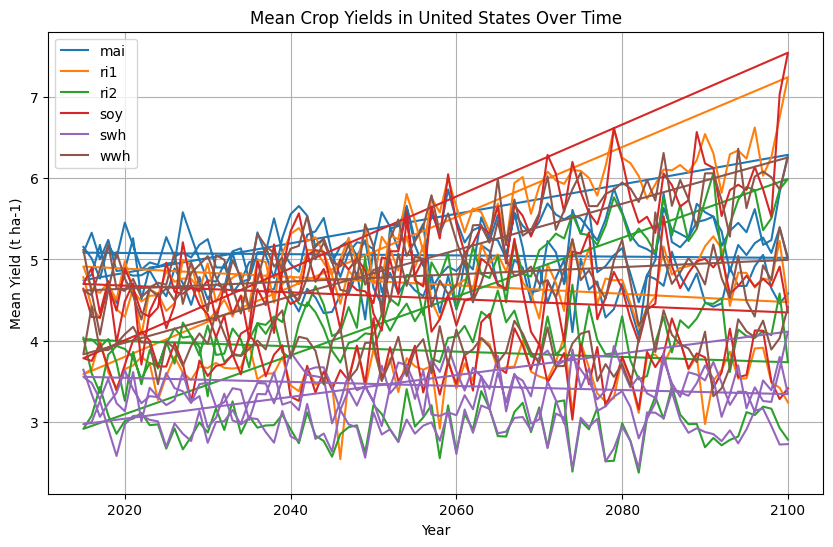


Processing region: Europe


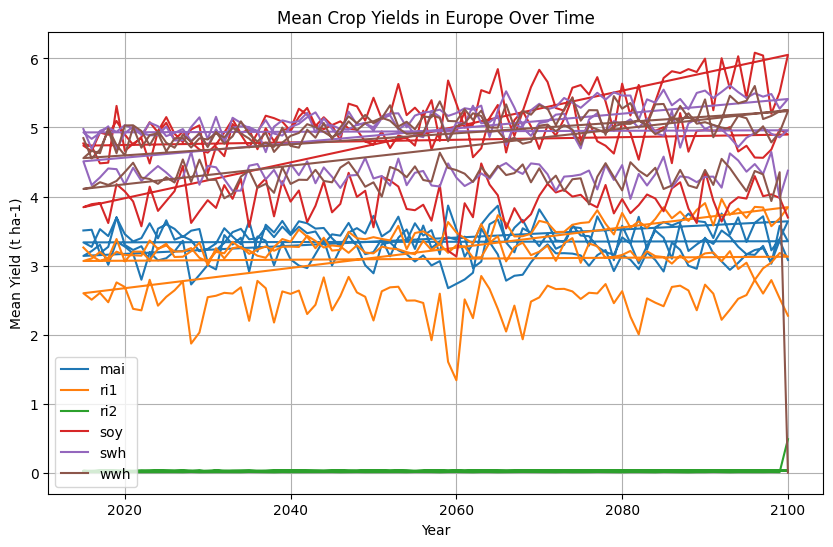


Processing region: Asia


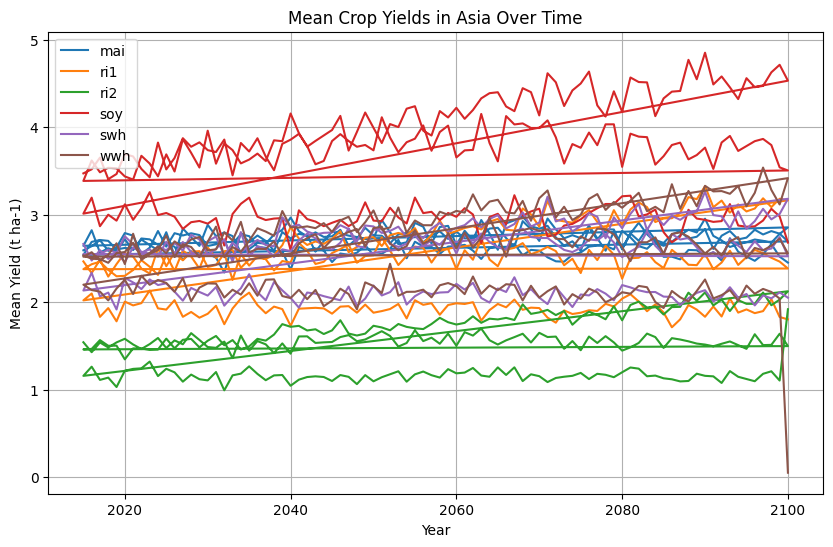


Processing region: Africa


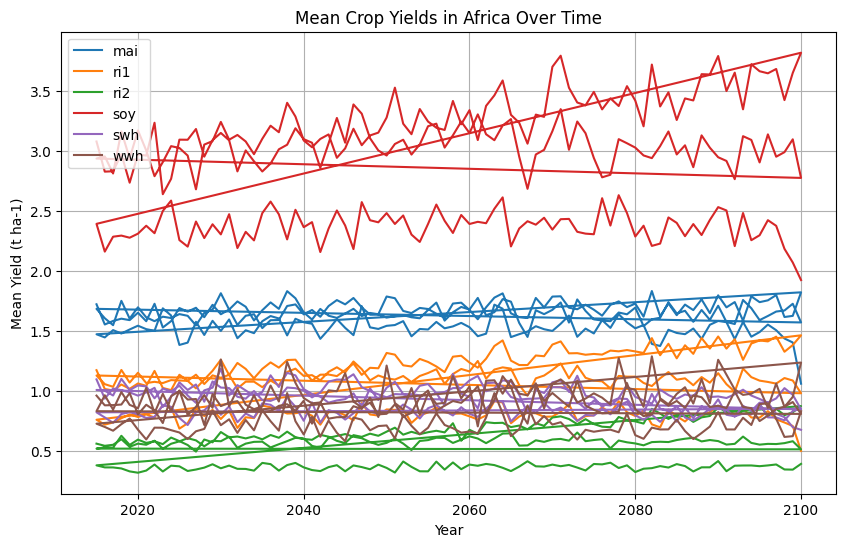

In [148]:
regions = {
    "United States": {"lat": slice(24, 49), "lon": slice(-125, -66)},
    "Europe": {"lat": slice(35, 71), "lon": slice(-25, 40)},  # Western Europe to Eastern Europe
    "Asia": {"lat": slice(5, 55), "lon": slice(60, 150)},  # Middle East to East Asia
    "Africa": {"lat": slice(-35, 37), "lon": slice(-20, 55)},  # Entire African continent
}

Ytrain = get_Ytrain(train_files)  # Load dataset

# Loop over each region
for region, coords in regions.items():
    print(f"\nProcessing region: {region}")

    # Select the region using `.where()` for flexibility
    lat_mask = (Ytrain.lat >= coords["lat"].start) & (Ytrain.lat <= coords["lat"].stop)
    lon_mask = (Ytrain.lon >= coords["lon"].start) & (Ytrain.lon <= coords["lon"].stop)
    Ytrain_region = Ytrain.where(lat_mask & lon_mask, drop=True)

    # Check if the region contains any data
    if Ytrain_region.to_array().isnull().all():
        print(f" Warning: No valid data available for {region}. Skipping plot.")
        continue  # Skip to the next region

    # Compute mean crop yields over lat/lon, handling NaNs
    region_crop_means = Ytrain_region.mean(dim=["lat", "lon"], skipna=True)

    # Plot mean crop yields over time
    plt.figure(figsize=(10, 6))
    for crop in region_crop_means.data_vars:
        if not region_crop_means[crop].isnull().all():  # Avoid plotting empty series
            plt.plot(region_crop_means.time, region_crop_means[crop], label=crop)

    plt.xlabel("Year")
    plt.ylabel("Mean Yield (t ha-1)")
    plt.title(f"Mean Crop Yields in {region} Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

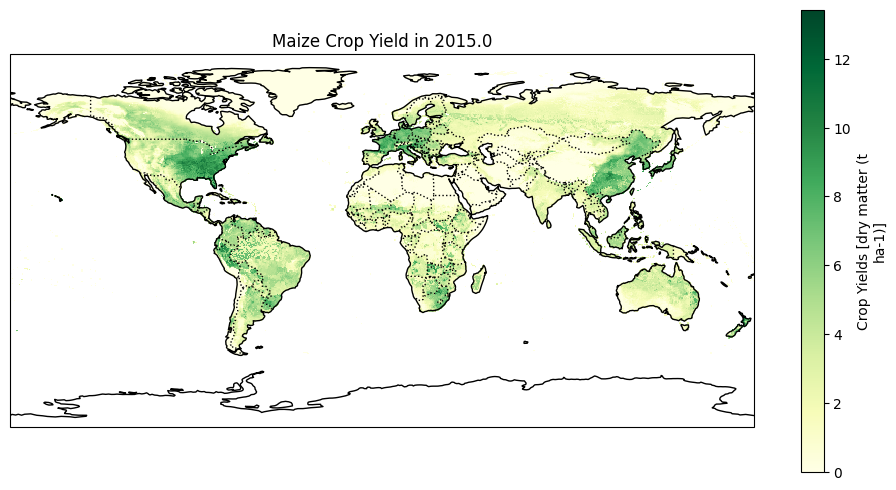

In [132]:
import cartopy.feature as cfeature

year_to_plot = get_Ytrain(train_files)['mai'].sel(time=2015).isel(time=0) 

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
year_to_plot.plot(ax=ax, cmap="YlGn")  

# Add coastlines and borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

plt.title(f"Maize Crop Yield in {year_to_plot.time.values}")
plt.show()

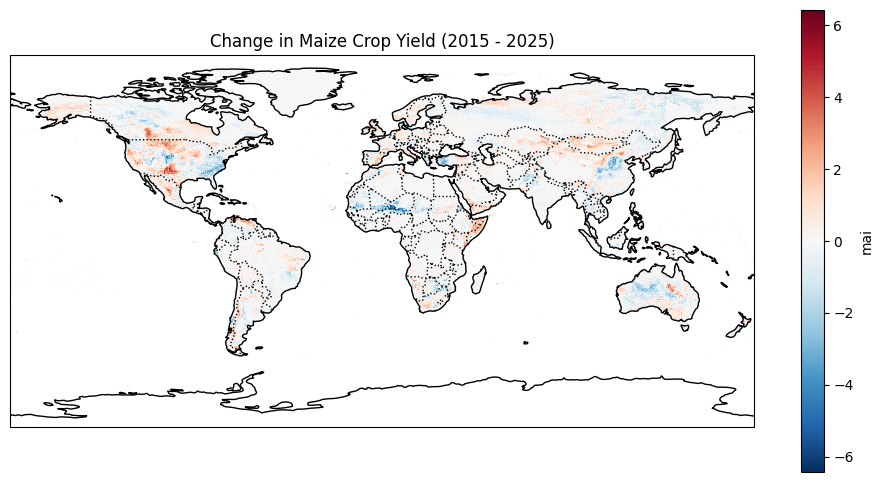

In [139]:
# Load crop yield data for 2015 and 2025
yields_2015 = get_Ytrain(train_files)['mai'].sel(time=2015).isel(time=0)
yields_2025 = get_Ytrain(train_files)['mai'].sel(time=2025).isel(time=0)

# Compute the difference (Change in Yield: 2025 - 2015)
yield_change = yields_2025 - yields_2015

# Plot the difference map
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Use a diverging colormap to highlight increases and decreases
cbar = yield_change.plot(ax=ax, cmap="RdBu_r", transform=ccrs.PlateCarree())

# Add coastlines and borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add title and colorbar
plt.title("Change in Maize Crop Yield (2015 - 2025)")

# Show the plot
plt.show()

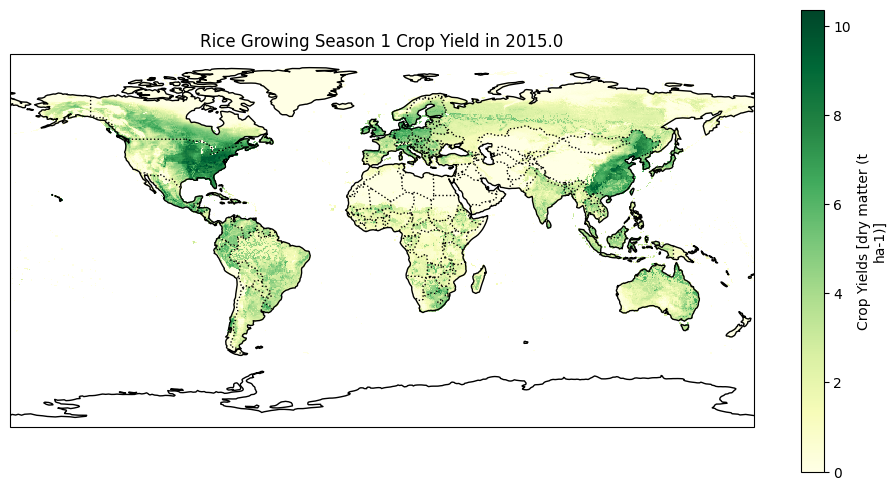

In [136]:
year_to_plot = get_Ytrain(train_files)['ri1'].sel(time=2015).isel(time=0) 

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
year_to_plot.plot(ax=ax, cmap="YlGn")  

# Add coastlines and borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

plt.title(f"Rice Growing Season 1 Crop Yield in {year_to_plot.time.values}")
plt.show()

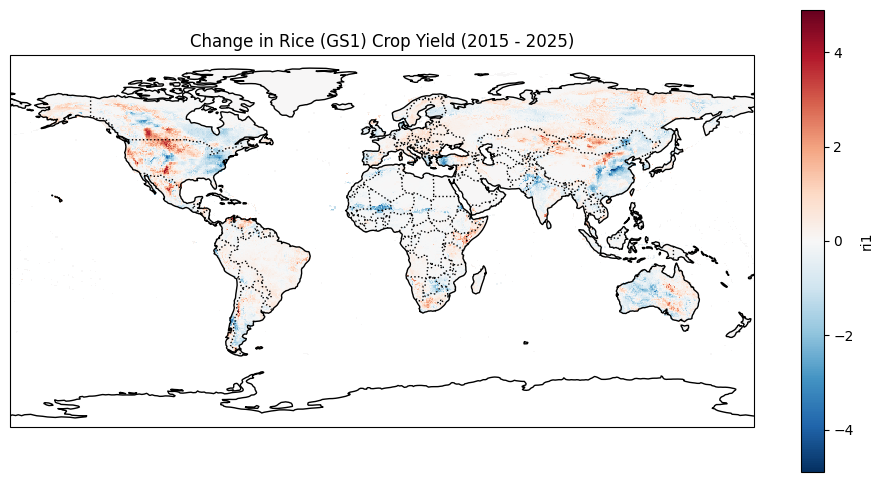

In [138]:
yields_2015 = get_Ytrain(train_files)['ri1'].sel(time=2015).isel(time=0)
yields_2025 = get_Ytrain(train_files)['ri1'].sel(time=2025).isel(time=0)

# Compute the difference (Change in Yield: 2025 - 2015)
yield_change = yields_2025 - yields_2015

# Plot the difference map
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Use a diverging colormap to highlight increases and decreases
cbar = yield_change.plot(ax=ax, cmap="RdBu_r", transform=ccrs.PlateCarree())

# Add coastlines and borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add title and colorbar
plt.title("Change in Rice (GS1) Crop Yield (2015 - 2025)")

# Show the plot
plt.show()

### Start of RF Modeling

In [153]:
#parameters dictionary
param_dict = {
    'mai': {
        'n_estimators': 250,
        'min_samples_split': 5,
        'min_samples_leaf': 7,
        'max_depth': 5
    },
    'ri1': {
        'n_estimators': 250,
        'min_samples_split': 5,
        'min_samples_leaf': 7,
        'max_depth': 5
    },
    'ri2': {
        'n_estimators': 250,
        'min_samples_split': 5,
        'min_samples_leaf': 7,
        'max_depth': 5
    },
    'soy': {
        'n_estimators': 250,
        'min_samples_split': 5,
        'min_samples_leaf': 7,
        'max_depth': 5
    },
    'swh': {
        'n_estimators': 250,
        'min_samples_split': 5,
        'min_samples_leaf': 7,
        'max_depth': 5
    },
    'wwh': {
        'n_estimators': 250,
        'min_samples_split': 5,
        'min_samples_leaf': 7,
        'max_depth': 5
    }
}


In [86]:
Ytrain = get_Ytrain(train_files)['mai'].values.reshape(-1, 360*720)  # Access the variable by its name
Xtrain = Xtrain.dropna(axis=0, how='any')

In [89]:
print(Ytrain.shape)
print(Xtrain.shape)


(258, 259200)
(258, 35)


In [108]:
# Aggregating Ytrain over space (by mean)
# Ytrain_mai = Ytrain_mai[~train_nan_mask]
Ytrain_mai = get_Ytrain(train_files)['mai'].mean(dim=['lat', 'lon'])  # Average over space
Ytrain_mai = Ytrain_mai.values.reshape(-1, 1) 

Ytest_mai = Ytest['mai'].mean(dim=['lat', 'lon'])  # Average over lat/lon
Ytest_mai = Ytest_mai.values.reshape(-1, 1)  # Reshape to match training

In [109]:
print("Processed Ytrain_mai shape:", Ytrain_mai.shape)  # Should be (258, 1)
print("Processed Ytest_mai shape:", Ytest_mai.shape)    # Should be (86, 1)
print("Predictions shape:", predictions.shape) 

Processed Ytrain_mai shape: (258, 1)
Processed Ytest_mai shape: (86, 1)
Predictions shape: (258, 259200)


In [105]:
print(Xtrain.shape, Xtest.shape)

(258, 35) (86, 35)


In [111]:
# Train RF model using the xarray DataArray
rf = rf_model(
    Xtrain,
    Ytrain_mai.ravel(),  # Pass reshaped xarray directly
    random_state=0,
    bootstrap=True,
    max_features='sqrt',
    **param_dict_mai  # Use variable-specific parameters
)
rf.train()


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [112]:
predictions = rf.predict(Xtest)

In [113]:
predictions

(array([2.15564945, 2.15312211, 2.15712211, 2.15565254, 2.16149495,
        2.15392929, 2.15348477, 2.1574991 , 2.16042874, 2.15347568,
        2.15769362, 2.1579831 , 2.16167054, 2.153413  , 2.15347568,
        2.15560243, 2.1557194 , 2.16473565, 2.15291607, 2.15770594,
        2.15800279, 2.16119156, 2.15653588, 2.15343244, 2.16452546,
        2.15611083, 2.16437359, 2.15971205, 2.15408165, 2.1607043 ,
        2.15513   , 2.15744332, 2.16147163, 2.1606266 , 2.15400331,
        2.16313665, 2.1575515 , 2.1548529 , 2.15573042, 2.16219582,
        2.15254519, 2.15742939, 2.1557194 , 2.15562687, 2.15515511,
        2.15695341, 2.15578694, 2.16323582, 2.15103431, 2.16869078,
        2.15410712, 2.15555051, 2.16762138, 2.15916067, 2.15591002,
        2.16608784, 2.15274559, 2.1559126 , 2.15384049, 2.15340764,
        2.16808375, 2.1513248 , 2.15582349, 2.15567952, 2.1667306 ,
        2.15702332, 2.15976658, 2.16841918, 2.15371642, 2.15649061,
        2.16655931, 2.16310053, 2.16715308, 2.15

In [116]:
# Extract the first element from the tuple for emulated results
predictions_array = predictions[0]

# Convert xarray to NumPy
if isinstance(predictions_array, xr.DataArray):
    predictions_array = predictions_array.values  # Convert to NumPy

print("Predictions Array Shape:", predictions_array.shape)

# Ensure it's at least 2D before applying mean
if predictions_array.ndim == 1:
    predictions_final = predictions_array.reshape(-1, 1)  # Ensure 2D
else:
    predictions_final = predictions_array.mean(axis=1).reshape(-1, 1)

print("Processed Predictions Shape:", predictions_final.shape)

Predictions Array Shape: (86,)
Processed Predictions Shape: (86, 1)


In [118]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(Ytest_mai, predictions_final)

print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.051309813472564886


In [149]:
print(f'Root Mean Squared Error: (RMSE): {np.sqrt(mse)}')

Root Mean Squared Error: (RMSE): 0.226516695792087


### Running RF model for years 2015-2100 each crop 

In [155]:
crop_variables = ['mai', 'ri1', 'ri2', 'soy', 'swh', 'wwh'] 

rf_models = {}  
predictions_dict = {} 

for crop in crop_variables:
    print(f"Processing crop: {crop}")

    # Process Ytrain: Average over lat/lon and reshape
    Ytrain_crop = get_Ytrain(train_files)[crop].mean(dim=['lat', 'lon'])
    Ytrain_crop = Ytrain_crop.values.reshape(-1, 1)

    # Process Ytest same as Ytrain
    Ytest_crop = Ytest[crop].mean(dim=['lat', 'lon'])
    Ytest_crop = Ytest_crop.values.reshape(-1, 1)

    # Training RF model
    rf = rf_model(
        Xtrain,
        Ytrain_crop.ravel(),  # Flatten for training
        random_state=0,
        bootstrap=True,
        max_features='sqrt',
        **param_dict[crop]  
    )
    rf.train()
    rf_models[crop] = rf  # Store trained model


    predictions = rf.predict(Xtest)
    predictions_array = predictions[0]

    # Convert to NumPy if it's an xarray DataArray
    if isinstance(predictions_array, xr.DataArray):
        predictions_array = predictions_array.values  

    print(f"{crop} Predictions Array Shape:", predictions_array.shape)

    # Make sure its 2D shape before computing mean
    if predictions_array.ndim == 1:
        predictions_final = predictions_array.reshape(-1, 1)
    else:
        predictions_final = predictions_array.mean(axis=1).reshape(-1, 1)

    print(f"Processed Predictions Shape for {crop}:", predictions_final.shape)

    # RMSE
    mse = mean_squared_error(Ytest_crop, predictions_final)
    print(f"Root Mean Squared Error (MSE) for {crop}: {np.sqrt(mse):}")

    # Store predictions
    predictions_dict[crop] = predictions_final

Processing crop: mai


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


mai Predictions Array Shape: (86,)
Processed Predictions Shape for mai: (86, 1)
Root Mean Squared Error (MSE) for mai: 0.226516695792087
Processing crop: ri1


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ri1 Predictions Array Shape: (86,)
Processed Predictions Shape for ri1: (86, 1)
Root Mean Squared Error (MSE) for ri1: 0.6312527591053365
Processing crop: ri2


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ri2 Predictions Array Shape: (86,)
Processed Predictions Shape for ri2: (86, 1)
Root Mean Squared Error (MSE) for ri2: 0.27676245601153515
Processing crop: soy


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


soy Predictions Array Shape: (86,)
Processed Predictions Shape for soy: (86, 1)
Root Mean Squared Error (MSE) for soy: 0.7880202479206337
Processing crop: swh


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


swh Predictions Array Shape: (86,)
Processed Predictions Shape for swh: (86, 1)
Root Mean Squared Error (MSE) for swh: 0.6161940951094063
Processing crop: wwh


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


wwh Predictions Array Shape: (86,)
Processed Predictions Shape for wwh: (86, 1)
Root Mean Squared Error (MSE) for wwh: 0.4976022530413162


### Running a small grid search 

In [159]:
# Define a small grid of hyperparameters to test
param_grid = {
    'n_estimators': [100, 250],  # Number of trees
    'min_samples_split': [2, 5],  # Min samples required to split a node
    'min_samples_leaf': [3, 7],   # Min samples in a leaf node
    'max_depth': [3, 5]           # Max depth of the trees
}

# Define the crops to model
crop_variables = ['mai', 'ri1', 'ri2', 'soy', 'swh', 'wwh']

rf_models = {}  
predictions_dict = {}  
best_params_dict = {}  # Store best parameters

for crop in crop_variables:
    print(f"Processing crop: {crop}")

    # Process Ytrain: Average over lat/lon and reshape
    Ytrain_crop = get_Ytrain(train_files)[crop].mean(dim=['lat', 'lon'])
    Ytrain_crop = Ytrain_crop.values.reshape(-1, 1)

    # Process Ytest
    Ytest_crop = Ytest[crop].mean(dim=['lat', 'lon'])
    Ytest_crop = Ytest_crop.values.reshape(-1, 1)

    best_rmse = float("inf")  # Track best RMSE
    best_params = None  # Track best parameter set
    best_model = None  # Track best trained model

    # Perform manual grid search over hyperparameters
    for params in itertools.product(*param_grid.values()):
        param_dict = dict(zip(param_grid.keys(), params))  # Convert tuple to dictionary

        # Train RF model with current hyperparameters
        rf = rf_model(
            Xtrain,
            Ytrain_crop.ravel(),  # Flatten for training
            random_state=0,
            bootstrap=True,
            max_features='sqrt',
            **param_dict  # Use selected parameters
        )
        rf.train()

        # Predict
        predictions = rf.predict(Xtest)
        predictions_array = predictions[0]

        # Convert to NumPy if it's an xarray DataArray
        if isinstance(predictions_array, xr.DataArray):
            predictions_array = predictions_array.values  

        # Ensure 2D shape before computing mean
        if predictions_array.ndim == 1:
            predictions_final = predictions_array.reshape(-1, 1)
        else:
            predictions_final = predictions_array.mean(axis=1).reshape(-1, 1)

        # Compute RMSE
        mse = mean_squared_error(Ytest_crop, predictions_final)
        rmse = np.sqrt(mse)

        print(f"RMSE for {crop} with params {param_dict}: {rmse}")

        # Update best parameters if current model is better
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = param_dict
            best_model = rf

    # Store the best trained model and parameters
    rf_models[crop] = best_model
    best_params_dict[crop] = best_params

    print(f"Best Parameters for {crop}: {best_params}")
    print(f"Best RMSE for {crop}: {best_rmse}")

    # Make final predictions with the best model
    predictions = best_model.predict(Xtest)
    predictions_array = predictions[0]

    # Convert to NumPy if it's an xarray DataArray
    if isinstance(predictions_array, xr.DataArray):
        predictions_array = predictions_array.values  

    # Ensure 2D shape
    if predictions_array.ndim == 1:
        predictions_final = predictions_array.reshape(-1, 1)
    else:
        predictions_final = predictions_array.mean(axis=1).reshape(-1, 1)

    predictions_dict[crop] = predictions_final

Processing crop: mai


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for mai with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3}: 0.2304814780309516
RMSE for mai with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 5}: 0.23233395228487397


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for mai with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 3}: 0.2214397981543903
RMSE for mai with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 5}: 0.22469226779184703


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for mai with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 3}: 0.2304814780309516
RMSE for mai with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 5}: 0.23233395228487397


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for mai with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 3}: 0.2214397981543903
RMSE for mai with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 5}: 0.22469226779184703


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for mai with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3}: 0.21891721732902775


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for mai with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 5}: 0.23132943839838532


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for mai with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 3}: 0.21881382622155288


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for mai with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 5}: 0.226516695792087


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for mai with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 3}: 0.21891721732902775


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for mai with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 5}: 0.23132943839838532


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for mai with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 3}: 0.21881382622155288


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for mai with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 5}: 0.226516695792087
Best Parameters for mai: {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 3}
Best RMSE for mai: 0.21881382622155288
Processing crop: ri1


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri1 with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3}: 0.6693240487918924
RMSE for ri1 with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 5}: 0.7055463292748311


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri1 with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 3}: 0.6581817007039121
RMSE for ri1 with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 5}: 0.6630986464780744


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri1 with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 3}: 0.6693240487918924


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri1 with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 5}: 0.7055463292748311
RMSE for ri1 with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 3}: 0.6581817007039121


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri1 with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 5}: 0.6630986464780744


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri1 with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3}: 0.6475354764916328


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri1 with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 5}: 0.6745089917884237


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri1 with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 3}: 0.6385775313840292


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri1 with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 5}: 0.6312527591053365


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri1 with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 3}: 0.6475354764916328


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri1 with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 5}: 0.6745089917884237


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri1 with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 3}: 0.6385775313840292


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri1 with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 5}: 0.6312527591053365
Best Parameters for ri1: {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 5}
Best RMSE for ri1: 0.6312527591053365
Processing crop: ri2


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri2 with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3}: 0.28145201118338875
RMSE for ri2 with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 5}: 0.2830008502937202


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri2 with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 3}: 0.2909948970525185
RMSE for ri2 with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 5}: 0.2862244438158957


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri2 with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 3}: 0.28145201118338875
RMSE for ri2 with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 5}: 0.2830008502937202


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri2 with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 3}: 0.2909948970525185
RMSE for ri2 with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 5}: 0.2862244438158957


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri2 with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3}: 0.28105138093694215


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri2 with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 5}: 0.27776664201691476


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri2 with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 3}: 0.28398962660873944


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri2 with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 5}: 0.27676245601153515


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri2 with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 3}: 0.28105138093694215


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri2 with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 5}: 0.27776664201691476


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri2 with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 3}: 0.28398962660873944


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for ri2 with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 5}: 0.27676245601153515
Best Parameters for ri2: {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 5}
Best RMSE for ri2: 0.27676245601153515
Processing crop: soy


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for soy with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3}: 0.8440084473719152
RMSE for soy with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 5}: 0.8489800852935993


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for soy with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 3}: 0.8224973542436538
RMSE for soy with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 5}: 0.8008351407141279


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for soy with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 3}: 0.8440084473719152
RMSE for soy with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 5}: 0.8489800852935993


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for soy with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 3}: 0.8224973542436538
RMSE for soy with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 5}: 0.8008351407141279


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for soy with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3}: 0.8160962480957743


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for soy with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 5}: 0.8336373265429283


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for soy with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 3}: 0.7957147695776966


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for soy with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 5}: 0.7880202479206337


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for soy with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 3}: 0.8160962480957743


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for soy with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 5}: 0.8336373265429283


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for soy with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 3}: 0.7957147695776966


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for soy with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 5}: 0.7880202479206337
Best Parameters for soy: {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 5}
Best RMSE for soy: 0.7880202479206337
Processing crop: swh


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for swh with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3}: 0.6669211680236298
RMSE for swh with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 5}: 0.6778948992271564


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for swh with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 3}: 0.6256025738451843
RMSE for swh with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 5}: 0.6215706450100987


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for swh with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 3}: 0.6669211680236298
RMSE for swh with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 5}: 0.6778948992271564


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for swh with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 3}: 0.6256025738451843
RMSE for swh with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 5}: 0.6215706450100987


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for swh with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3}: 0.6400540617878642


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for swh with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 5}: 0.6684108666215108


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for swh with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 3}: 0.6082958309796292


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for swh with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 5}: 0.6161940951094063


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for swh with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 3}: 0.6400540617878642


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for swh with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 5}: 0.6684108666215108


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for swh with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 3}: 0.6082958309796292


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for swh with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 5}: 0.6161940951094063
Best Parameters for swh: {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 3}
Best RMSE for swh: 0.6082958309796292
Processing crop: wwh


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for wwh with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3}: 0.5317575093476798
RMSE for wwh with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 5}: 0.5489434647703915


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for wwh with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 3}: 0.5142379742919762
RMSE for wwh with params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 5}: 0.5060666553078034


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for wwh with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 3}: 0.5317575093476798
RMSE for wwh with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 5}: 0.5489434647703915


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for wwh with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 3}: 0.5142379742919762
RMSE for wwh with params {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 5}: 0.5060666553078034


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for wwh with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3}: 0.504852722438389


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for wwh with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 5}: 0.5284691328893049


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for wwh with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 3}: 0.48954254993308405


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for wwh with params {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 5}: 0.4976022530413162


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for wwh with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 3}: 0.504852722438389


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for wwh with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 5}: 0.5284691328893049


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for wwh with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 3}: 0.48954254993308405


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for wwh with params {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 5}: 0.4976022530413162
Best Parameters for wwh: {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 3}
Best RMSE for wwh: 0.48954254993308405


In [160]:
# Define the crops to model
crop_variables = ['mai', 'ri1', 'ri2', 'soy', 'swh', 'wwh']

rf_models = {}  
predictions_dict = {}  

for crop in crop_variables:
    print(f"\nTraining RF model for crop: {crop}")

    # Process Ytrain: Average over lat/lon and reshape
    Ytrain_crop = get_Ytrain(train_files)[crop].mean(dim=['lat', 'lon'])
    Ytrain_crop = Ytrain_crop.values.reshape(-1, 1)

    # Process Ytest
    Ytest_crop = Ytest[crop].mean(dim=['lat', 'lon'])
    Ytest_crop = Ytest_crop.values.reshape(-1, 1)

    # Train RF model using best parameters
    rf = rf_model(
        Xtrain,
        Ytrain_crop.ravel(),  # Flatten for training
        random_state=0,
        bootstrap=True,
        max_features='sqrt',
        **best_params_dict[crop]  # Use best parameters for this crop
    )
    rf.train()
    rf_models[crop] = rf  # Store trained model

    # Predict on test data
    predictions = rf.predict(Xtest)
    predictions_array = predictions[0]

    # Convert to NumPy if it's an xarray DataArray
    if isinstance(predictions_array, xr.DataArray):
        predictions_array = predictions_array.values  

    print(f"{crop} Predictions Array Shape:", predictions_array.shape)

    # Ensure it's 2D shape before computing mean
    if predictions_array.ndim == 1:
        predictions_final = predictions_array.reshape(-1, 1)
    else:
        predictions_final = predictions_array.mean(axis=1).reshape(-1, 1)

    print(f"Processed Predictions Shape for {crop}:", predictions_final.shape)

    # Compute RMSE
    mse = mean_squared_error(Ytest_crop, predictions_final)
    rmse = np.sqrt(mse)

    print(f"Root Mean Squared Error (RMSE) for {crop}: {rmse}")

    # Store predictions
    predictions_dict[crop] = predictions_final


Training RF model for crop: mai


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


mai Predictions Array Shape: (86,)
Processed Predictions Shape for mai: (86, 1)
Root Mean Squared Error (RMSE) for mai: 0.21881382622155288

Training RF model for crop: ri1


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ri1 Predictions Array Shape: (86,)
Processed Predictions Shape for ri1: (86, 1)
Root Mean Squared Error (RMSE) for ri1: 0.6312527591053365

Training RF model for crop: ri2


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ri2 Predictions Array Shape: (86,)
Processed Predictions Shape for ri2: (86, 1)
Root Mean Squared Error (RMSE) for ri2: 0.27676245601153515

Training RF model for crop: soy


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


soy Predictions Array Shape: (86,)
Processed Predictions Shape for soy: (86, 1)
Root Mean Squared Error (RMSE) for soy: 0.7880202479206337

Training RF model for crop: swh


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


swh Predictions Array Shape: (86,)
Processed Predictions Shape for swh: (86, 1)
Root Mean Squared Error (RMSE) for swh: 0.6082958309796292

Training RF model for crop: wwh


/Users/nilaymenon/opt/anaconda3/envs/rf_env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


wwh Predictions Array Shape: (86,)
Processed Predictions Shape for wwh: (86, 1)
Root Mean Squared Error (RMSE) for wwh: 0.48954254993308405
